Found GPU at: 
Mounted at /content/drive


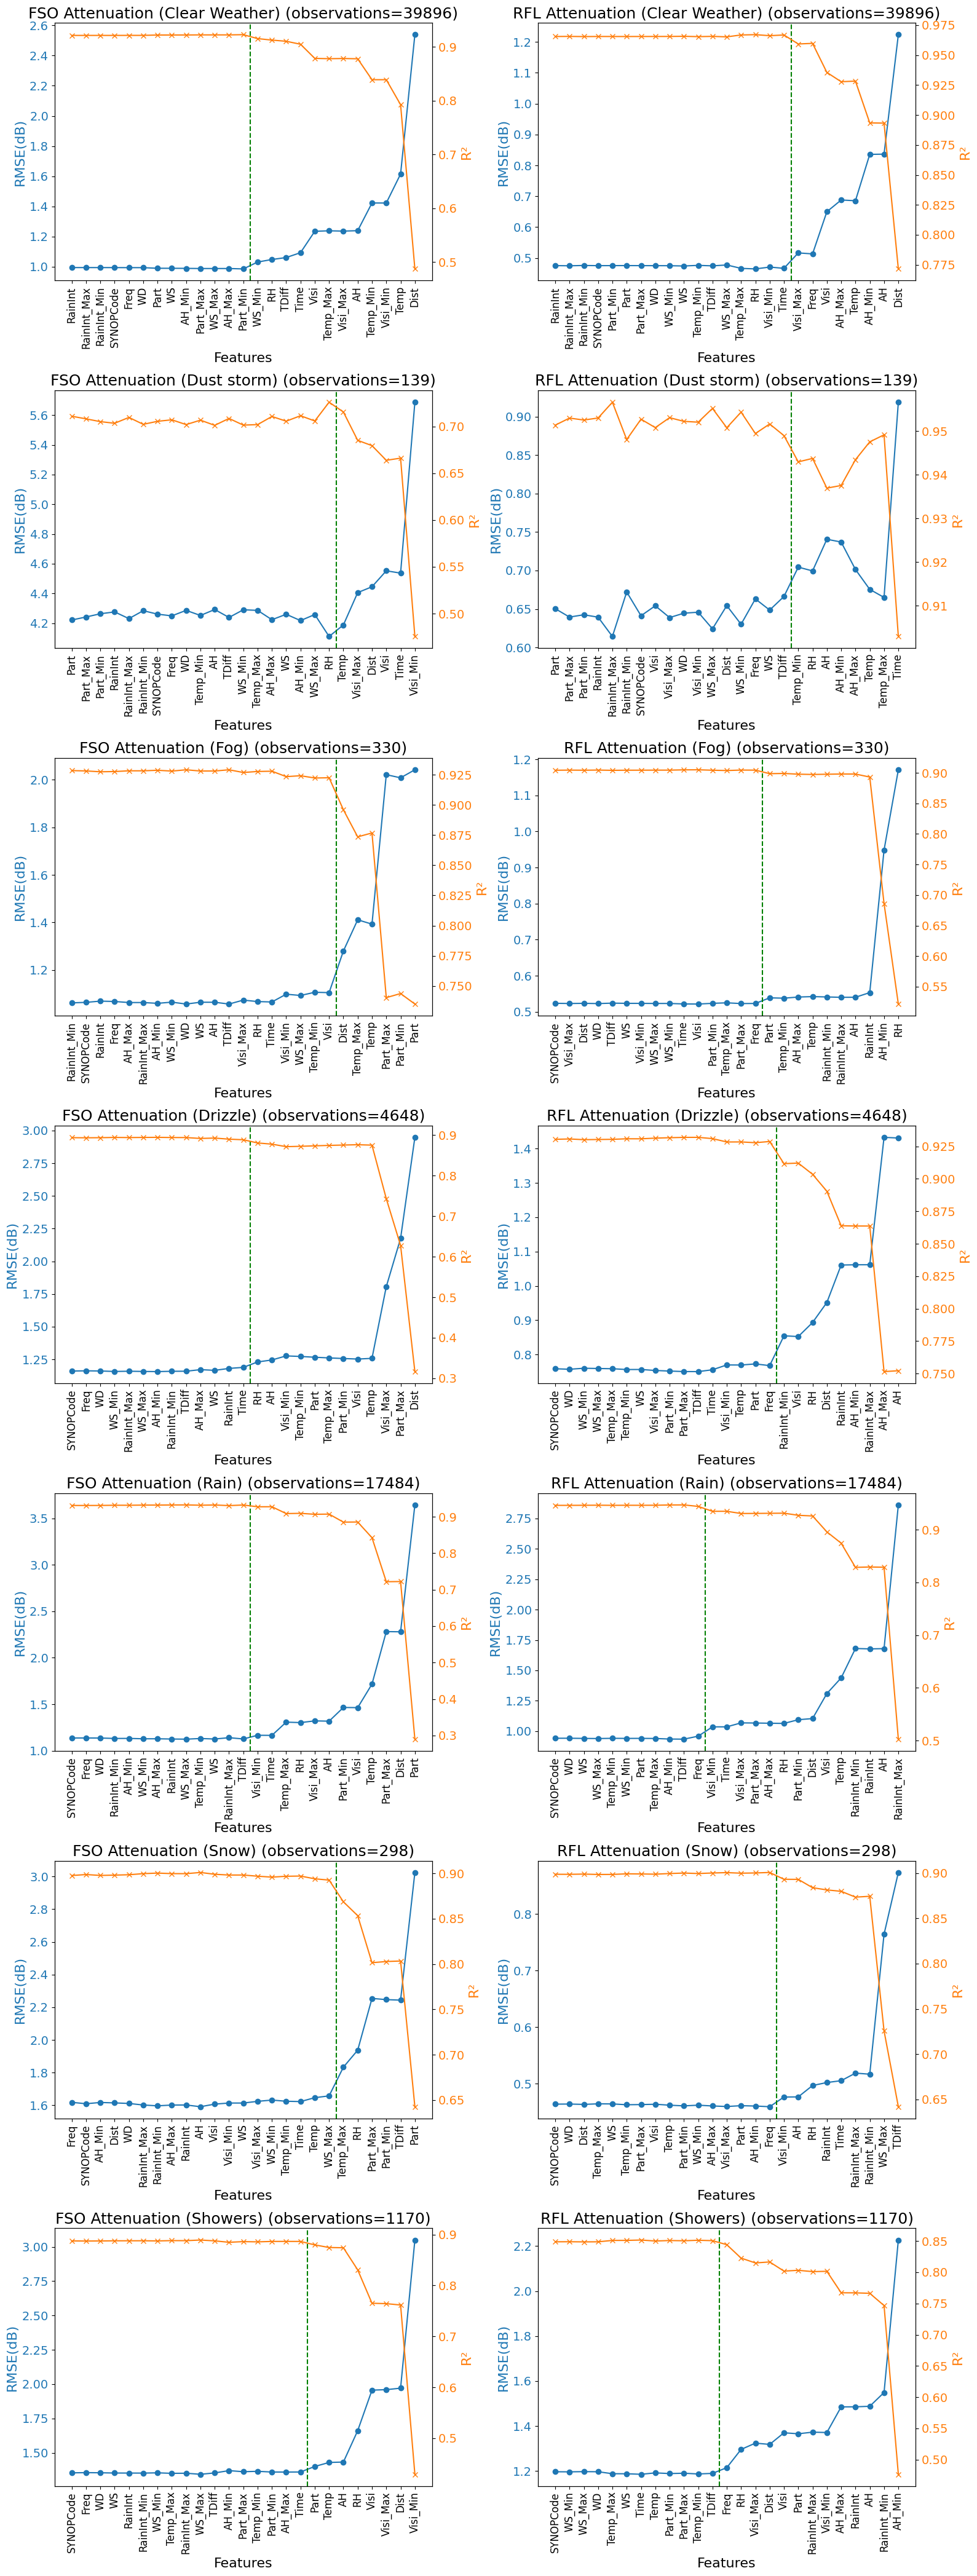

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

print('Found GPU at: {}'.format(device_name))
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def rank_feature_importance(X, y):
    S = list(X.columns)
    R = []

    while S:
        model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
        model.fit(X[S], y)

        importances = model.feature_importances_
        y_pred = model.oob_prediction_
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        R.append({
            'Features': S.copy(),
            'RMSE': rmse,
            'R2': r2,
            'Least Important Feature': None
        })

        least_important_feature = S[np.argmin(importances)]
        S.remove(least_important_feature)

        R[-1]['Least Important Feature'] = least_important_feature

    return pd.DataFrame(R)

def plot_predictor_importance(ranking_table, title, num_observations, ax, manual_dividing_line=False, keep_features=6):
    ax.set_xlabel('Features', fontsize=16)
    ax.set_ylabel('RMSE(dB)', color='tab:blue', fontsize=16)
    ax.plot(ranking_table.index, ranking_table['RMSE'], color='tab:blue', marker='o', label='RMSE')
    ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=14)

    ax2 = ax.twinx()
    ax2.set_ylabel('R²', color='tab:orange', fontsize=16)
    ax2.plot(ranking_table.index, ranking_table['R2'], color='tab:orange', marker='x', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

    if manual_dividing_line:
        dividing_point = len(ranking_table) - keep_features
    else:
        dividing_point = None
        threshold = 0.005
        for i in range(1, len(ranking_table)):
            rmse_change = (ranking_table.loc[i, 'RMSE'] - ranking_table.loc[i-1, 'RMSE']) / ranking_table.loc[i-1, 'RMSE']
            r2_change = (ranking_table.loc[i-1, 'R2'] - ranking_table.loc[i, 'R2']) / ranking_table.loc[i-1, 'R2']
            if rmse_change > threshold and r2_change > threshold:
                dividing_point = i - 1
                break

    if dividing_point is not None:
        ax.axvline(x=dividing_point + 0.5, color='green', linestyle='--', label='Dividing Line')

    ax.set_title(f'{title} (observations={num_observations})', fontsize=18)
    ax.set_xticks(ranking_table.index)
    ax.set_xticklabels(ranking_table['Least Important Feature'], rotation=90, fontsize=12)
    plt.tight_layout()

    if dividing_point is not None:
        important_features = ranking_table.loc[dividing_point + 1:, 'Least Important Feature'].tolist()
        return important_features
    else:
        return []

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time',  'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
from google.colab import drive
drive.mount('/content/drive')

data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train, X_temp, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val, X_test, y_val_fso, y_test_fso = train_test_split(X_temp, y_temp_fso, test_size=0.5, random_state=42)

X_train, X_temp, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val, X_test, y_val_rfl, y_test_rfl = train_test_split(X_temp, y_temp_rfl, test_size=0.5, random_state=42)

# Reset indices for alignment
X_train = X_train.reset_index(drop=True)
X_temp = X_temp.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train_fso = y_train_fso.reset_index(drop=True)
y_temp_fso = y_temp_fso.reset_index(drop=True)
y_val_fso = y_val_fso.reset_index(drop=True)
y_test_fso = y_test_fso.reset_index(drop=True)

y_train_rfl = y_train_rfl.reset_index(drop=True)
y_temp_rfl = y_temp_rfl.reset_index(drop=True)
y_val_rfl = y_val_rfl.reset_index(drop=True)
y_test_rfl = y_test_rfl.reset_index(drop=True)

# Now further divide the training data into subsets based on SYNOPCode
models_fso = {}
important_features_fso = {}
models_rfl = {}
important_features_rfl = {}

synop_codes_order = [0, 3, 4, 5, 6, 7, 8]
synop_code_labels = ['Clear Weather', 'Dust storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

fig, axs = plt.subplots(len(synop_codes_order), 2, figsize=(16, 6 * len(synop_codes_order)))

for i, synop_code in enumerate(synop_codes_order):
    manual_dividing_line = (synop_code == 3)
    keep_features_fso = 7
    keep_features_rfl = 9

    subset_train_fso = X_train[X_train['SYNOPCode'] == synop_code]
    y_subset_train_fso = y_train_fso[X_train['SYNOPCode'] == synop_code]
    if not subset_train_fso.empty:
        results_fso = rank_feature_importance(subset_train_fso, y_subset_train_fso)
        important_features_fso[synop_code] = plot_predictor_importance(results_fso, f'FSO Attenuation ({synop_code_labels[i]})', len(subset_train_fso), axs[i, 0], manual_dividing_line, keep_features_fso)

    subset_train_rfl = X_train[X_train['SYNOPCode'] == synop_code]
    y_subset_train_rfl = y_train_rfl[X_train['SYNOPCode'] == synop_code]
    if not subset_train_rfl.empty:
        results_rfl = rank_feature_importance(subset_train_rfl, y_subset_train_rfl)
        important_features_rfl[synop_code] = plot_predictor_importance(results_rfl, f'RFL Attenuation ({synop_code_labels[i]})', len(subset_train_rfl), axs[i, 1], manual_dividing_line, keep_features_rfl)

plt.tight_layout()
plt.show()

# Save the important predictors for each SYNOPCode to files for use in the second segment
import pickle

with open('important_features_fso.pkl', 'wb') as f:
    pickle.dump(important_features_fso, f)

with open('important_features_rfl.pkl', 'wb') as f:
    pickle.dump(important_features_rfl, f)

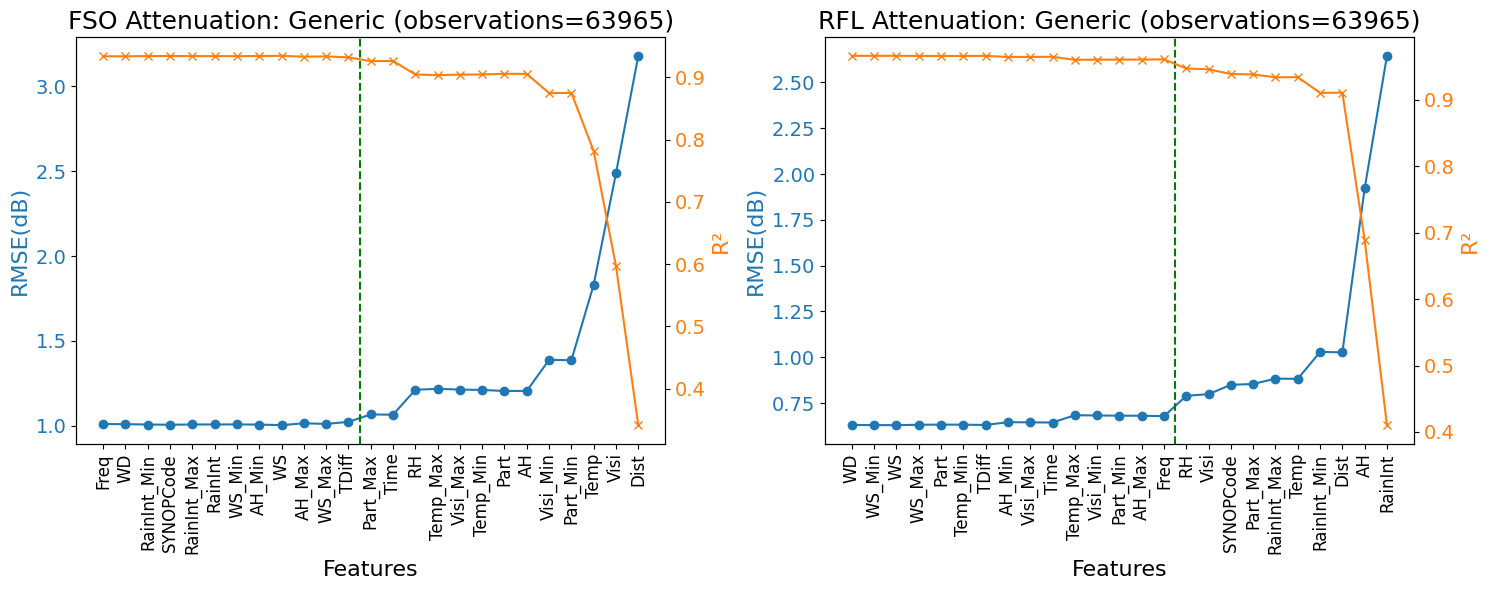

FSO Model - RMSE: 0.9936389930879125, R²: 0.933684728722319
RFL Model - RMSE: 0.7675982260823679, R²: 0.9497664231194065


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt

def rank_feature_importance(X, y):
    S = list(X.columns)
    R = []

    while S:
        model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
        model.fit(X[S], y)

        importances = model.feature_importances_
        y_pred = model.oob_prediction_
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        R.append({
            'Features': S.copy(),
            'RMSE': rmse,
            'R2': r2,
            'Least Important Feature': None
        })

        least_important_feature = S[np.argmin(importances)]
        S.remove(least_important_feature)

        R[-1]['Least Important Feature'] = least_important_feature

    return pd.DataFrame(R)

def plot_predictor_importance(ranking_table, title, num_observations, ax, manual_dividing_line=False):
    ax.set_xlabel('Features', fontsize=16)
    ax.set_ylabel('RMSE(dB)', color='tab:blue', fontsize=16)
    ax.plot(ranking_table.index, ranking_table['RMSE'], color='tab:blue', marker='o', label='RMSE')
    ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=14)

    ax2 = ax.twinx()
    ax2.set_ylabel('R²', color='tab:orange', fontsize=16)
    ax2.plot(ranking_table.index, ranking_table['R2'], color='tab:orange', marker='x', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

    if manual_dividing_line:
        dividing_point = len(ranking_table) - keep_features
    else:
        dividing_point = None
        threshold = 0.005
        for i in range(1, len(ranking_table)):
            rmse_change = (ranking_table.loc[i, 'RMSE'] - ranking_table.loc[i-1, 'RMSE']) / ranking_table.loc[i-1, 'RMSE']
            r2_change = (ranking_table.loc[i-1, 'R2'] - ranking_table.loc[i, 'R2']) / ranking_table.loc[i-1, 'R2']
            if rmse_change > threshold and r2_change > threshold:
                dividing_point = i - 1
                break

    if dividing_point is not None:
        ax.axvline(x=dividing_point + 0.5, color='green', linestyle='--', label='Dividing Line')

    ax.set_title(f'{title} (observations={num_observations})', fontsize=18)
    ax.set_xticks(ranking_table.index)
    ax.set_xticklabels(ranking_table['Least Important Feature'], rotation=90, fontsize=12)
    plt.tight_layout()

    if dividing_point is not None:
        important_features = ranking_table.loc[dividing_point + 1:, 'Least Important Feature'].tolist()
        return important_features
    else:
        return []

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att": "FSO_Att",
        "RFL_Att": "RFL_Att",
        "AbsoluteHumidity": "AH",
        "AbsoluteHumidityMax": "AH_Max",
        "AbsoluteHumidityMin": "AH_Min",
        "Distance": "Dist",
        "Frequency": "Freq",
        "Particulate": "Part",
        "ParticulateMax": "Part_Max",
        "ParticulateMin": "Part_Min",
        "RainIntensity": "RainInt",
        "RainIntensityMax": "RainInt_Max",
        "RainIntensityMin": "RainInt_Min",
        "RelativeHumidity": "RH",
        "SYNOPCode": "SYNOPCode",
        "Temperature": "Temp",
        "TemperatureDifference": "TDiff",
        "TemperatureMax": "Temp_Max",
        "TemperatureMin": "Temp_Min",
        "Time": "Time",
        "Visibility": "Visi",
        "VisibilityMax": "Visi_Max",
        "VisibilityMin": "Visi_Min",
        "WindDirection": "WD",
        "WindSpeed": "WS",
        "WindSpeedMax": "WS_Max",
        "WindSpeedMin": "WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

def train_model(X_train, y_train, important_features):
    X_train = X_train[important_features]
    model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
    model.fit(X_train, y_train)
    return model

def get_predictions_and_metrics(X_test, y_test, model, important_features):
    X_test = X_test[important_features]
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return predictions, rmse, r2

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train, X_temp, y_train_fso, y_temp_fso, y_train_rfl, y_temp_rfl = train_test_split(X, y_fso, y_rfl, test_size=0.3, random_state=42)
X_val, X_test, y_val_fso, y_test_fso, y_val_rfl, y_test_rfl = train_test_split(X_temp, y_temp_fso, y_temp_rfl, test_size=0.5, random_state=42)

# Plot predictor importance graphs for the entire training set
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
results_fso = rank_feature_importance(X_train, y_train_fso)
important_features_fso = plot_predictor_importance(results_fso, 'FSO Attenuation: Generic', len(X_train), axs[0], manual_dividing_line=False)

results_rfl = rank_feature_importance(X_train, y_train_rfl)
important_features_rfl = plot_predictor_importance(results_rfl, 'RFL Attenuation: Generic', len(X_train), axs[1], manual_dividing_line=False)
plt.show()

# Train models using the important predictors
model_fso = train_model(X_train, y_train_fso, important_features_fso)
model_rfl = train_model(X_train, y_train_rfl, important_features_rfl)

# Generate and evaluate predictions for FSO
predictions_fso, rmse_fso, r2_fso = get_predictions_and_metrics(X_test, y_test_fso, model_fso, important_features_fso)

# Generate and evaluate predictions for RFL
predictions_rfl, rmse_rfl, r2_rfl = get_predictions_and_metrics(X_test, y_test_rfl, model_rfl, important_features_rfl)
